# Podcasts Data Analysis

In [1]:
import sqlite3 as sql

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import spearmanr

In [2]:
conn = sql.connect('database.sqlite')

# Introduction

In this project, we conduct an in-depth analysis of the complex domain of podcasts, aiming to uncover patterns and insights. The target population of this project is the set of all podcasts listed on Apple Podcasts from 2005-12-09 till 2023-02-16, as the dataset used for the analysis was sourced from Kaggle. 

After comprehensively understanding the data, we will formulate and test three hypotheses. The hypotheses are as follows:

- The increase in podcast count by year does not have an effect on the average rating of podcasts.
- All podcast categories have the same average rating.
- The length of a review doest not affects the rating of a podcast

We will use statistical techniques to validate our hypotheses, including the Spearman correlation coefficient and the Analysis of Variance (ANOVA) test. We will also use confidence intervals and p-values to determine the statistical significance of our results.

# Exploratory Data Analysis

Our analysis is centered around three main tables:

- `podcasts`: This table contains information about the podcasts, such as their unique identifiers and other related details.
- `reviews`: This table holds data related to the reviews given to the podcasts, including the ratings and content.
- `categories`: This table provides information about each podcast's categories, which can help understand the classification of

To gain a better understanding of the data, we will examine the first five rows of each table.

In [3]:
pd.read_sql("""
SELECT *
FROM podcasts
LIMIT 5""", conn)

,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-...,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerst...,Cornerstone Baptist Church of Orlando
2,a0004b1ef445af9dc84dad1e7821b1e3,139076942,mystery-dancing-in-the-dark,https://podcasts.apple.com/us/podcast/mystery-...,Mystery: Dancing in the Dark
3,a00071f9aaae9ac725c3a586701abf4d,1332508972,kts-money-matters,https://podcasts.apple.com/us/podcast/kts-mone...,KTs Money Matters
4,a000a500f06555f81220c3eb641aded7,1544900779,word-on-the-street-w-dreak-swift,https://podcasts.apple.com/us/podcast/word-on-...,Word on the Street w/ Dreak Swift


In [4]:
pd.read_sql("""
SELECT *
FROM reviews
LIMIT 5""", conn)

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00


In [5]:
pd.read_sql("""
SELECT *
FROM categories
LIMIT 5""", conn)

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts-design


Now that we better understand our data, we will start to analyze it.

- Initially, we will calculate the total number of podcasts.

In [6]:
print(f"There are {pd.read_sql('SELECT COUNT(podcast_id) '
                               'FROM podcasts', conn).iloc[0, 0]} podcasts in the database.")

There are 110024 podcasts in the database.


- Lowest and Highest rating of podcasts

In [7]:
print(f"The minimum rating of podcast is "
      f"{pd.read_sql('SELECT MIN(rating) AS MinRating '
                     'FROM reviews', conn).iloc[0, 0]} and the maximum rating is "
      f"{pd.read_sql('SELECT MAX(rating) AS MaxRating '
                     'FROM reviews', conn).iloc[0, 0]}.")

The minimum rating of podcast is 1 and the maximum rating is 5.


- To understand better the quality of podcasts,  now will count the mean of ratings and calculate a 95% confidence interval

In [8]:
ratings = pd.read_sql("SELECT rating "
                      "FROM reviews", conn)['rating']
mean = round(np.mean(ratings), 3)
sem = stats.sem(ratings)
df = len(ratings) - 1
confidence = 0.95

ci = stats.t.interval(confidence, df, loc=mean, scale=sem)

ci = (round(ci[0], 3), round(ci[1], 3))

print(f"Mean of ratings: {mean}")
print(f"Confidence interval: {ci}")

Mean of ratings: 4.627
Confidence interval: (4.626, 4.628)


With a large sample size, we can confidently assert that the quality of podcasts is high, as the average rating, with a 95% confidence level, falls between 4.626 and 4.628.

- Identifying the first and final dates of reviews

When I was looking at the first and last dates of reviews, I noticed some dates in Arabic numerals—so the easiet approach ( queries min and max) to get the first date and the last one didn't work. The translated command query is not supported with sqlite3. So, I had to use pandas to translate Arabic numerals to Western numerals. I also changed the date format for easier readability.

In [9]:
first_reviews = pd.read_sql("""
SELECT created_at
FROM reviews
ORDER BY created_at ASC
LIMIT 5
""", conn)

last_reviews = pd.read_sql("""
SELECT created_at
FROM reviews
ORDER BY created_at DESC
LIMIT 5
""", conn)

first_last = pd.concat([first_reviews, last_reviews])
first_last = first_last.reset_index(drop=True)

translation_table = str.maketrans('٠١٢٣٤٥٦٧٨٩', '0123456789')
first_last['created_at'] = first_last['created_at'].str.translate(translation_table)

first_last['created_at'] = pd.to_datetime(first_last['created_at'], format='%Y-%m-%dT%H:%M:%S%z')
min_date = first_last['created_at'].min()
max_date = first_last['created_at'].max()

print(f"First date: {min_date}")
print(f"Last date: {max_date}")

First date: 2005-12-09 21:41:01-07:00
Last date: 2023-02-16 08:38:37-07:00


The dataset for the years 2005 and 2023 is incomplete. Therefore, for subsequent analyses requiring a year-by-year comparison, the data range will be restricted to 2006 through 2022.

-  Count of different categories

In [10]:
print(f"There are {pd.read_sql('SELECT COUNT (DISTINCT category) '
                               'FROM categories', conn).iloc[0, 0]} different categories.")

There are 110 different categories.


We should understand better how categories are made, and it may be possible to group them into a few categories. This way, it would be easier to compare categories.

- First, we are creating a data frame of categories that includes podcast id and category.

In [11]:
categories = pd.read_sql("""
SELECT *
FROM categories""", conn)
categories['category'] = categories['category'].str.capitalize()

- Checking for null values and duplicates

In [12]:
print(f"There are {categories.isnull().sum().sum()} null values in the data frame.")

There are 0 null values in the data frame.


In [13]:
print(f"There are {categories.duplicated().sum()} duplicates in the data frame.")

There are 0 duplicates in the data frame.


- There were no null values or duplicates in the data frame. Consequently, we are now going to analyze how categories are constructed. We will investigate whether a podcast could belong to more than one category.

In [14]:
pd.read_sql("""
SELECT podcast_id, COUNT(category) AS category_count
FROM categories
GROUP BY podcast_id
ORDER BY category_count DESC
LIMIT 10""", conn)

,podcast_id,category_count
0,be905117ff9b3a13b1a065801241903b,8
1,c4be70db3c16d3607bd7ae4999cb6e86,8
2,fa8c359031380cd4f3b38358c8a75f92,8
3,a7ae747331094b205de1e093011f7e1e,7
4,af4c9ab7e54007e755ed9f063b89a328,7
5,b0a1de130a5229e8692c8b808df131af,7
6,b2adba62e19cecb3b7123fc7db3c80ce,7
7,b80b40b6b6787935970e5153fdfcfd4c,7
8,b834bcf94406863e8484f4ee1f4d7bdf,7
9,c46849fea7dad4653131ca16977da152,7


Podcasts can belong to more than one category. Now, we will examine the three podcasts with the most categories. This will aid us in better understanding how categories are structured.

In [15]:
pd.read_sql("""
SELECT *
FROM categories
WHERE podcast_id IN ('be905117ff9b3a13b1a065801241903b', 'c4be70db3c16d3607bd7ae4999cb6e86', 'fa8c359031380cd4f3b38358c8a75f92')""",
            conn)

,podcast_id,category
0,be905117ff9b3a13b1a065801241903b,arts
1,be905117ff9b3a13b1a065801241903b,business
2,be905117ff9b3a13b1a065801241903b,business-entrepreneurship
3,be905117ff9b3a13b1a065801241903b,christianity
4,be905117ff9b3a13b1a065801241903b,education
5,be905117ff9b3a13b1a065801241903b,religion-spirituality
6,be905117ff9b3a13b1a065801241903b,society-culture
7,be905117ff9b3a13b1a065801241903b,society-culture-personal-journals
8,c4be70db3c16d3607bd7ae4999cb6e86,business
9,c4be70db3c16d3607bd7ae4999cb6e86,business-careers


Upon examining the data frame, it was observed that categories are split into main categories and sub-categories. This conclusion was drawn after reviewing more than just these three podcasts. We will divide the category column into two separate columns: one for the main category and another for the sub-category.

In [16]:
categories[['category', 'sub_category']] = categories['category'].str.split('-', n=1, expand=True)
categories.head(10)

,podcast_id,category,sub_category
0,c61aa81c9b929a66f0c1db6cbe5d8548,Arts,None
1,c61aa81c9b929a66f0c1db6cbe5d8548,Arts,performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,Music,None
3,ad4f2bf69c72b8db75978423c25f379e,Arts,None
4,ad4f2bf69c72b8db75978423c25f379e,Arts,design
5,ad4f2bf69c72b8db75978423c25f379e,Education,None
6,ad4f2bf69c72b8db75978423c25f379e,Society,culture
7,f2970432aad718a000ebac10e48ae6b0,Arts,None
8,f2970432aad718a000ebac10e48ae6b0,Arts,performing-arts
9,f2970432aad718a000ebac10e48ae6b0,Society,culture


In [17]:
categories_to_replace = ['Hinduism', 'Islam', 'Judaism', 'Christianity', 'Buddhism']
categories['category'] = categories['category'].replace(categories_to_replace, 'Religion')

In [18]:
print(f"There are {categories['category'].nunique()} categories.")

There are 20 categories.


Now, we have 20 categories instead of 110. It will be easier to compare categories. Now, we are going to check the count of each category.

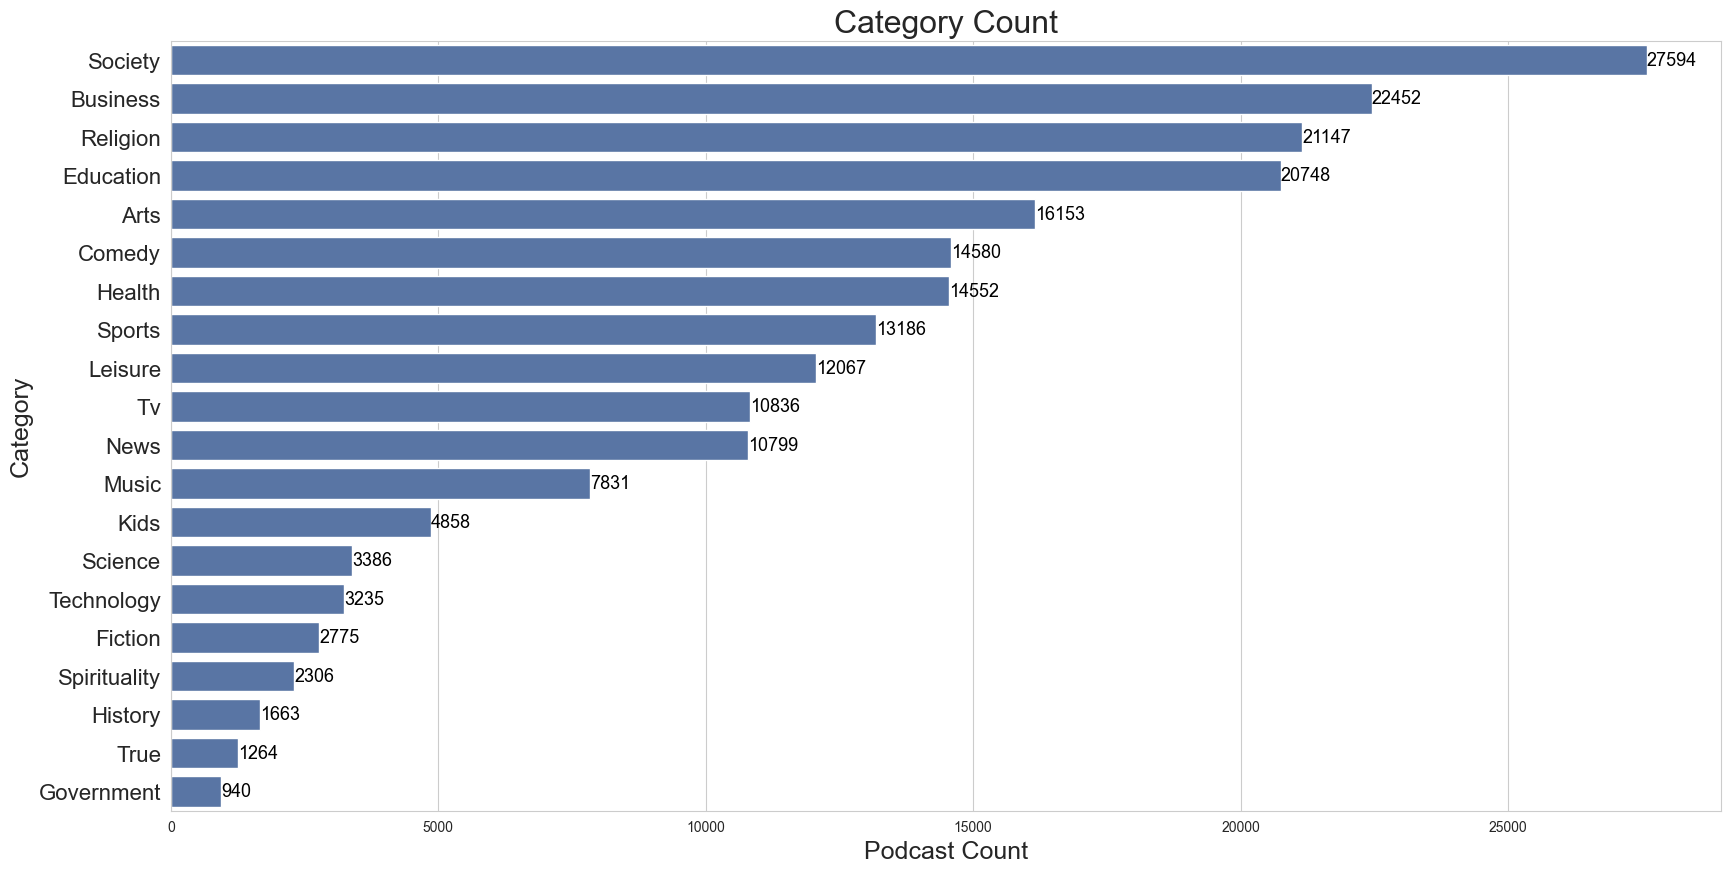

In [19]:
plt.figure(figsize=(20, 10))
sns.set_palette('deep')
sns.countplot(y='category', data=categories, order=categories['category'].value_counts().index)
for index, value in enumerate(categories['category'].value_counts()):
    plt.text(value, index, str(value), ha='left', va='center', fontsize=13, color='black')
plt.tick_params(axis='y', labelsize=16)
plt.title('Category Count', fontsize=23)
plt.xlabel('Podcast Count', fontsize=18)
plt.ylabel('Category', fontsize=18)
plt.show()

In [20]:
print(f'The most popular categories are {", ".join(categories["category"].value_counts().index[:3].tolist())}')
print(f'The least popular categories are {", ".join(categories["category"].value_counts().index[-3:].tolist())}')

The most popular categories are Society, Business, Religion
The least popular categories are History, True, Government


Now when we have a better understanding of the data, we can start Hypothesis testing.

## Hypothesis no.1

Typically, quantity and quality are inversely proportional. Is this the case for podcasts? Our first hypothesis is about this.

$$H_{0}: \text{The increase in podcast count by year does not have an effect on the average rating of podcasts.}$$

$$H_{1}: \text{The increase in podcast count by year has an effect on the average rating of podcasts. 
}$$

This dataset doesn't indicate when the podcast was created; it only shows when the reviews were made. We will use the year the first review was created as the year the podcast was created, as initial reviews are typically made in the first few days of podcast creation.

- We will calculate the difference between the count of unique podcast IDs in the podcasts table and the count of unique podcast IDs in the reviews table. This will help us determine if there is any data loss, as some podcasts might not yet have any reviews.

In [21]:
pd.read_sql("""
SELECT COUNT(DISTINCT podcast_id)
FROM podcasts""", conn).iloc[0, 0] - pd.read_sql("""
SELECT COUNT(DISTINCT podcast_id)
FROM reviews""", conn).iloc[0, 0]

-1520

The reviews table contains 1520 more unique podcast IDs than the podcasts table. This indicates that not only is there no data loss, but the reviews table actually contains additional podcasts.

- Now, we're going to plot the average rating of podcasts and count of podcasts by year.

In [22]:
yearly_counts = pd.read_sql("""
SELECT strftime('%Y', created_at) as Year, COUNT(DISTINCT podcast_id) as PodcastCount
FROM reviews
WHERE strftime('%Y', created_at) BETWEEN '2006' AND '2022'
GROUP BY Year
""", conn)

yearly_avg_ratings = pd.read_sql("""
SELECT strftime('%Y', created_at) as Year, AVG(rating) as AvgRating
FROM reviews
WHERE strftime('%Y', created_at) BETWEEN '2006' AND '2022'
GROUP BY Year
""", conn)

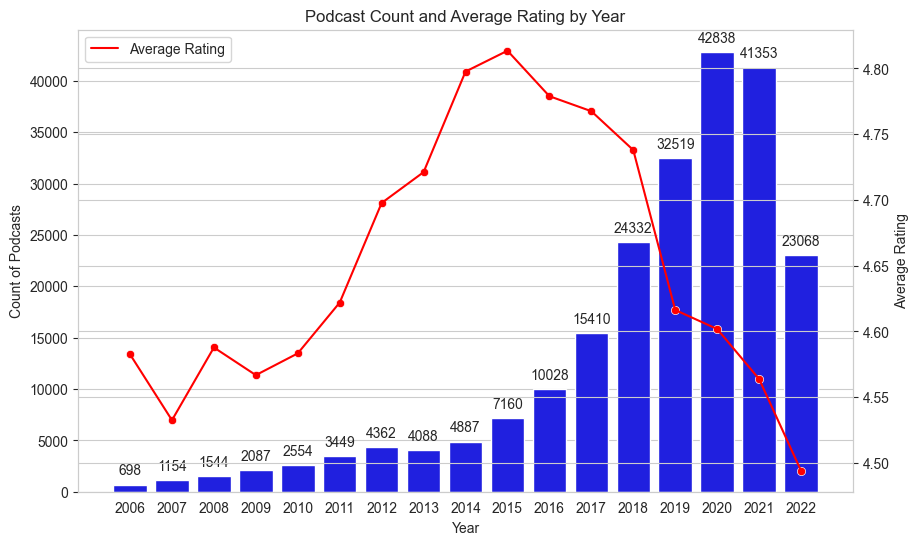

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 6))

barplot = sns.barplot(data=yearly_counts, x='Year', y='PodcastCount', ax=ax1, color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count of Podcasts')

for p in barplot.patches:
    barplot.annotate(format(int(p.get_height())),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 10),
                     textcoords='offset points')

ax2 = ax1.twinx()

sns.lineplot(data=yearly_avg_ratings, x='Year', y='AvgRating', ax=ax2, color='red', label='Average Rating',
             legend=False)
sns.scatterplot(data=yearly_avg_ratings, x='Year', y='AvgRating', color='red', ax=ax2, legend=False)
ax2.set_title('Podcast Count and Average Rating by Year')
ax2.set_ylabel('Average Rating')

fig.legend(loc="upper left", bbox_to_anchor=(0, 1), bbox_transform=ax1.transAxes)

plt.xticks(rotation=45)

plt.show()

Based on the plot of 'Podcast Count and Average Rating by Year', we can draw the following conclusions:

- The number of podcasts has been increasing over the years. This indicates a growing interest in podcast production.
- In 2022, there was a significant drop in the number of podcasts. I have checked the data. The data may have missing months, but all the months' data was in. So, it might be related to COVID-19. That's why there was a massive increase in 2020 and a drop in 2022.
- The average rating of podcasts does not show a consistent trend over the years. It fluctuates and does not seem to correlate directly with the increase in podcast count, but we could see trend from 2015 year average rating of podcasts is decreasing.

Now, we will examine whether our data follows a normal distribution. We will visualize the data distribution using histograms and perform the Shapiro-Wilk test, a popular statistical test for normality. The Shapiro-Wilk test calculates a W statistic that indicates how closely the shape of the data matches the shape of a normal distribution. A W statistic close to 1 indicates that the distribution is similar to a normal distribution. 

In addition to the W statistic, the Shapiro-Wilk test provides a p-value. If the p-value is less than the chosen significance level (we set it at 0.05), we reject the null hypothesis that the data is normally distributed. Therefore, a p-value greater than 0.05 suggests the data is normally distributed.

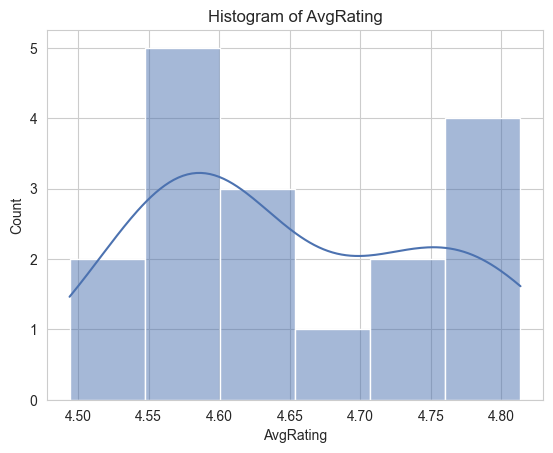

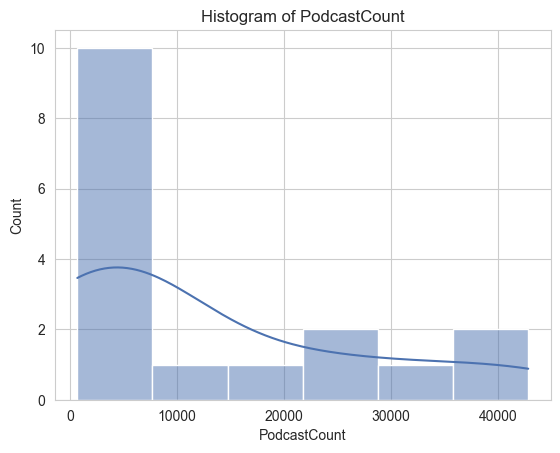

Shapiro-Wilk Test for AvgRating: ShapiroResult(statistic=0.9186474084854126, pvalue=0.1400948166847229)
Shapiro-Wilk Test for PodcastCount: ShapiroResult(statistic=0.7956163287162781, pvalue=0.001767581095919013)


In [49]:
data_avg_rating = yearly_avg_ratings['AvgRating']
data_counts = yearly_counts['PodcastCount']

sns.histplot(data_avg_rating, kde=True)
plt.title('Histogram of AvgRating')
plt.show()

sns.histplot(data_counts, kde=True)
plt.title('Histogram of PodcastCount')
plt.show()

print("Shapiro-Wilk Test for AvgRating:", stats.shapiro(data_avg_rating))
print("Shapiro-Wilk Test for PodcastCount:", stats.shapiro(data_counts))

The yearly average rating and podcast count histograms indicate that the data does not follow a normal distribution. This observation is further supported by the results of the Shapiro-Wilk test, which returned p-values less than 0.05. As a result, we conclude that it is not a normal distribution.

Given this, we cannot use the Pearson correlation coefficient, which assumes a normal distribution, to examine the relationship between the average rating and podcast count per year. Instead, we will employ the Spearman correlation coefficient.

The Spearman correlation coefficient is a non-parametric correlation measure, making no assumptions about the data distribution. It assesses how well the relationship between two variables can be described using a monotonic function. A monotonic relationship is one where the variables increase or decrease together, but not necessarily at a constant rate. The coefficient ranges from -1 to 1. A coefficient close to 1 indicates a strong positive relationship, a coefficient close to -1 indicates a strong negative relationship and a coefficient close to 0 indicates no relationship.

In addition to the Spearman correlation coefficient, we will also calculate the associated p-value. The p-value is a statistical metric that calculates the likelihood of obtaining the observed data, assuming that the null hypothesis is accurate. In this scenario, the null hypothesis states that there is no correlation between the average rating and yearly podcast count. We reject the null hypothesis if the p-value is less than a predetermined significance level (in our case, 0.05). This would suggest a statistically significant correlation between the average rating and yearly podcast count.

In [50]:
merged_yearly = pd.merge(yearly_counts, yearly_avg_ratings, on='Year')
corr, p_value = spearmanr(merged_yearly['PodcastCount'], merged_yearly['AvgRating'])

print(f'Spearman correlation coefficient: {round(corr, 3)}')
print(f'p-value: {round(p_value, 3)}')

Spearman correlation coefficient: 0.225
p-value: 0.384


The Spearman correlation coefficient is 0.225, suggesting a weak positive relationship between the two variables. However, the p-value is 0.38, greater than the significance level of 0.05. Therefore, we do not reject the null hypothesis. This implies that we do not have sufficient evidence to assert that there is a statistically significant correlation between the two variables.

# Hypothesis no.2

The second hypothesis is about the average ratings of podcasts. It recognizes that every podcast will have listeners with different opinions - some will like it, and some will not.

$$H_{0}: \text{All podcast categories have the same average rating.}$$

$$H_{1}: \text{Not all podcast categories have the same average rating.}$$

- First, We will check the average rating of each category and will plot it.

In [25]:
podcast_rating = pd.read_sql("""
SELECT podcast_id, rating
FROM reviews""", conn)
podcast_rating = pd.merge(podcast_rating, categories, on='podcast_id')
podcast_rating = podcast_rating.drop(['podcast_id', 'sub_category'], axis=1)

In [26]:
category_avg_rating = podcast_rating.groupby('category').mean().round(2).reset_index()
category_avg_rating = category_avg_rating.sort_values(by='rating', ascending=False)

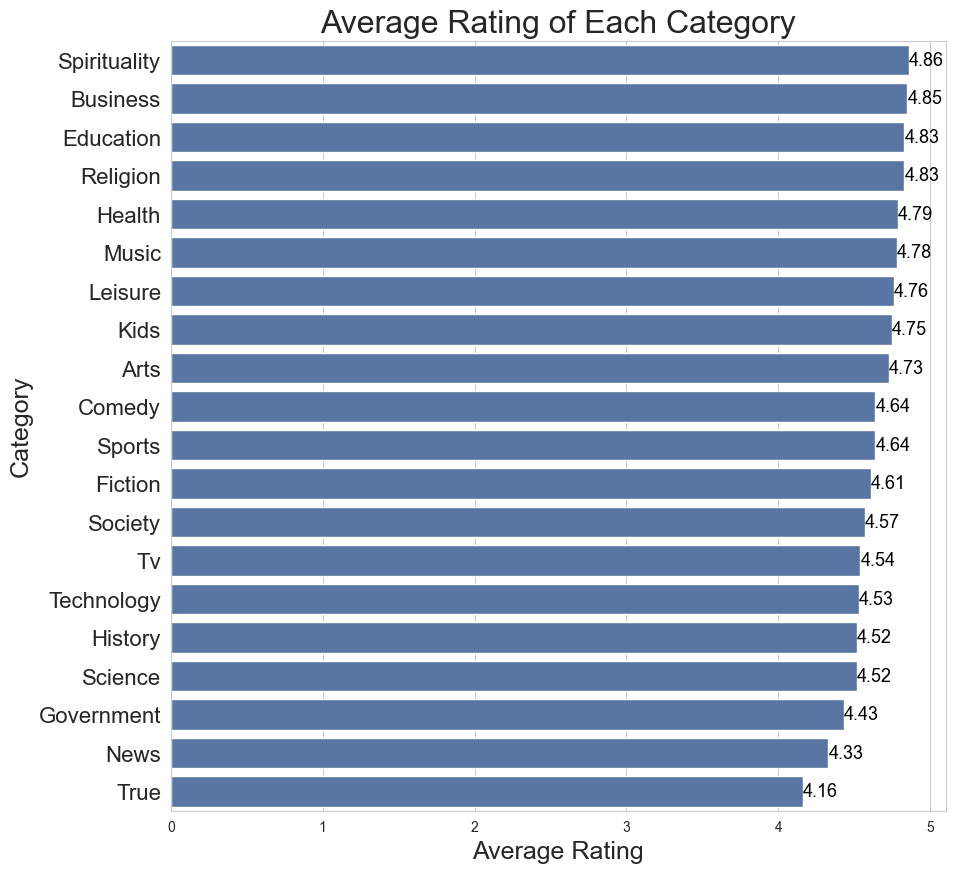

In [27]:
plt.figure(figsize=(10, 10))
sns.set_palette('deep')
sns.barplot(x='rating', y='category', data=category_avg_rating)
for index, value in enumerate(category_avg_rating['rating']):
    plt.text(value, index, str(value), ha='left', va='center', fontsize=13, color='black')
plt.tick_params(axis='y', labelsize=16)
plt.title('Average Rating of Each Category', fontsize=23)
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Category', fontsize=18)
plt.show()

The bar plot of the average rating of each podcast category reveals that there are differences in the average ratings across categories. Some categories have higher average ratings than others. However, it's important to note that this plot does not provide statistical evidence of these differences.

In the following step, we aim to examine whether the average rating of each podcast category significantly differs from the others. To accomplish this, we will utilize the Analysis of Variance (ANOVA) test, a statistical technique used to identify if there are substantial differences between the means of three or more unrelated groups.

The ANOVA test produces two values: the F-statistic and the p-value. The F-statistic, a ratio of two variances, is employed to compute the p-value. If the null hypothesis is accurate, we anticipate the F-statistic to be close to 1.0 most of the time. A high F-statistic indicates that the variation among group means is more significant than expected by chance, suggesting that the group means are significantly different. The p-value is then used to ascertain the statistical significance of the differences between the group means.

We will establish a significance level of 5%. We can reject the null hypothesis if the p-value is less than 0.05. In this context, the null hypothesis asserts that all podcast categories have the same average rating. If the p-value is less than 0.05, it would indicate that at least one category has a different average rating, thereby supporting the alternative hypothesis.

In [28]:
f_stat, p_value = f_oneway(*[group["rating"].values for name, group in podcast_rating.groupby("category")])

print(f'F statistic: {f_stat}')
print(f'p-value: {p_value}')

F statistic: 7161.701683057838
p-value: 0.0


Based on the Analysis of Variance (ANOVA) test results, the p-value is less than the significance level of 0.05. This indicates a statistically significant difference in the average ratings among the podcast categories. Therefore, we reject the null hypothesis that all podcast categories have the same average rating. This supports the alternative hypothesis that not all podcast categories have the same average rating.

# Hypothesis no.3

The third hypothesis is related to the length of reviews

$$H_{0}: \text{The length of a review does not affect the rating of a podcast.}$$

$$H_{1}: \text{The length of a review affects the rating of a podcast.}$$

To better understand the podcast data, we will analyze the distribution of review lengths according to their ratings. We will use a boxplot to visualize the distribution of review lengths for each distinct rating. Additionally, we will use a point plot to display the average review length for each rating.

In [29]:
reviews = pd.read_sql("SELECT rating, content FROM reviews", conn)
reviews['review_length'] = reviews['content'].apply(len)

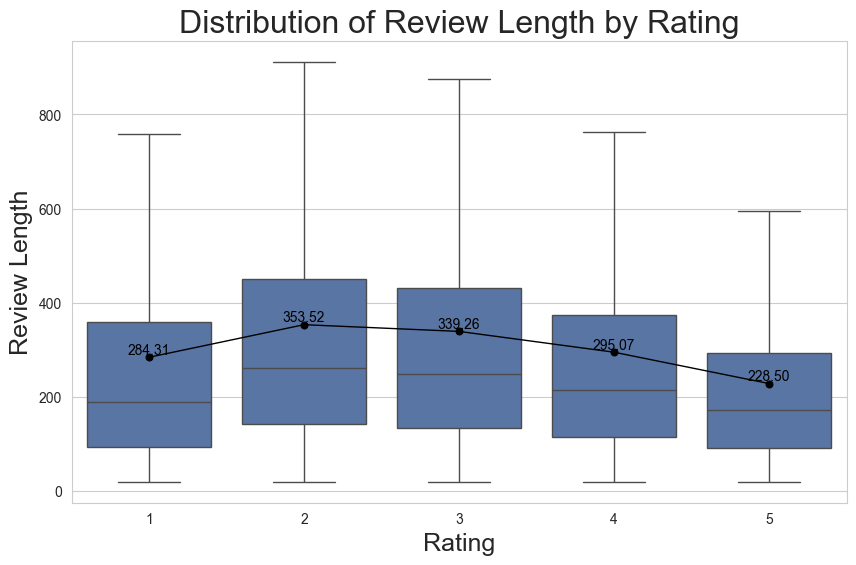

In [40]:
plt.figure(figsize=(10, 6))
sns.set_palette('deep')
sns.boxplot(x='rating', y='review_length', data=reviews, showfliers=False)
mean_values = reviews.groupby('rating')['review_length'].mean()
sns.pointplot(x='rating', y='review_length', data=reviews, color='black', markersize=5, linewidth=1, estimator=np.mean, errorbar=None)
for i, mean_value in enumerate(mean_values):
    plt.text(x=i, y=mean_value, s=f'{mean_value:.2f}', ha='center', va='bottom', color='black')
plt.title('Distribution of Review Length by Rating', fontsize=23)
plt.xlabel('Rating', fontsize=18)
plt.ylabel('Review Length', fontsize=18)
plt.show()

From the boxplot, it's observed that the review lengths vary significantly across different ratings. Some ratings have a more comprehensive range of review lengths, indicating more variability in how long the reviews are. The mean review length also differs across ratings, as the point plot shows.

However, the boxplot and point plot do not provide statistical evidence of these differences. Further statistical tests, like ANOVA, will confirm whether these differences are statistically significant.

Now, we will carry out an ANOVA test, similar to the one performed in hypothesis no 2, to determine if the length of reviews influences the podcast's rating. We're setting a significance level of 5%, which means we can reject the null hypothesis if the p-value is less than 0

In [32]:
f_stat, p_value = f_oneway(*[group["review_length"].values for name, group in reviews.groupby("rating")])

print(f'F statistic: {f_stat}')
print(f'p-value: {p_value}')

F statistic: 7709.66949214662
p-value: 0.0


Based on the Analysis of Variance (ANOVA) test results for the third hypothesis, the p-value is less than the significance level of 0.05. This indicates a statistically significant difference in the length of reviews among the different podcast ratings. Therefore, we reject the null hypothesis that the length of a review does not affect the rating of a podcast. This supports the alternative hypothesis that the length of a review affects a podcast's rating.

# Conclusion

In conclusion, this project provided a comprehensive analysis of podcast data, focusing on understanding the intricate details and patterns. We analyzed three primary tables: podcasts, reviews, and categories. 

We formulated and tested three hypotheses related to podcast ratings and categories. The first hypothesis examined the relationship between the increase in podcast count by year and the average rating of podcasts. The results indicated no significant correlation between these two variables. 

The second hypothesis tested whether all podcast categories have the same average rating. The results from the ANOVA test showed a statistically significant difference in the average ratings among the podcast categories, indicating that not all podcast categories have the same average rating.

The third hypothesis investigated the impact of review length on the podcast's rating. The results showed a statistically significant difference in the length of reviews among the different podcast ratings, suggesting that the length of a review does affect a podcast's rating.

We employed various statistical techniques throughout the project, including the Pearson correlation coefficient and the Analysis of Variance (ANOVA) test, to validate our hypotheses. We also used confidence intervals and p-values to determine the statistical significance of our results.


# Suggestions for Further Analysis

For further analysis, the following areas could be explored:

1. **Temporal Analysis**: Investigate the trends of podcast ratings over time. It would be interesting to see if there are specific periods, such as holidays or weekends, when ratings tend to be higher or lower.

2. **Podcast Analysis**: Examine the characteristics of the podcasts themselves. Analyzing if there are any common features among the highest-rated podcasts, such as length or category, could provide valuable insights.

3. **Author Analysis**: In this analysis, we didn't examine the authors . It could be insightful to analyze. We could investigate if there are any common features among the highest-rated authors. For instance, do they tend to produce longer or shorter podcasts, or do they belong to certain categories?